In [76]:
import numpy as np
import pandas as pd
from datetime import timedelta

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

pd.set_option('display.max_rows', 500)

In [77]:
from scipy.optimize import curve_fit

In [226]:
!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv

--2020-03-28 18:45:27--  https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv
Resolving raw.githubusercontent.com... 151.101.132.133
Connecting to raw.githubusercontent.com|151.101.132.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67604 (66K) [text/plain]
Saving to: ‘dpc-covid19-ita-regioni.csv’

dpc-covid19-ita-reg 100%[===================>]  66.02K  --.-KB/s    in 0.03s   

2020-03-28 18:45:28 (2.02 MB/s) - ‘dpc-covid19-ita-regioni.csv’ saved [67604/67604]



In [227]:
data = pd.read_csv('dpc-covid19-ita-regioni.csv')

In [228]:
!rm dpc-covid19-ita-regioni.csv

In [216]:
data.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
688,2020-03-27T17:00:00,ITA,9,Toscana,43.769231,11.255889,1053,274,1327,1843,3170,197,103,177,3450,23746,NaN,NaN
689,2020-03-27T17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,341,66,407,757,1164,70,125,102,1391,4923,NaN,NaN
690,2020-03-27T17:00:00,ITA,10,Umbria,43.106758,12.388247,149,46,195,629,824,54,39,21,884,6137,NaN,NaN
691,2020-03-27T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,91,24,115,298,413,35,2,37,452,1252,NaN,NaN
692,2020-03-27T17:00:00,ITA,5,Veneto,45.434905,12.338452,1536,338,1874,4774,6648,508,536,313,7497,83627,NaN,NaN


In [229]:
#get rid of time stamp

data['date_only'] = np.array([d.date() for d in pd.to_datetime(data.data)]).astype(str)

In [230]:
data.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,date_only
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5,NaN,NaN,2020-02-24
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,NaN,NaN,2020-02-24
2,2020-02-24T18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1,NaN,NaN,2020-02-24
3,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1,NaN,NaN,2020-02-24
4,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10,NaN,NaN,2020-02-24


In [252]:
def func_exp(x, a, c, d):
    return a*np.exp(-c*x)+d

def func_exp_2(x, x0, a, c):
    return a*np.exp(c*(x-x0))

def func_line(x,m,b):
    return m*x + b

Assumption is exponential growth with varying time scale (default = looking at each week).

In [269]:
def analyze_region(name, data, nchunks = 4, dailies = True, save = False):
    
    dp = data[data['denominazione_regione'] == name]
        
    # fit different time periods
    
    for i in range(nchunks):

        cases = np.array_split(dp.totale_casi.values, nchunks)[i]
        days = np.array_split(range(len(dp.totale_casi)), nchunks)[i]
        
    #plot cases
    
    plt.figure(figsize=(14,7))
    plt.title('Statistics, region: '+str(name), fontsize = 14)
    plt.plot(dp.date_only, dp.totale_casi,'o-', label = 'Total new cases')
    plt.plot(dp.date_only, dp.dimessi_guariti,'o-', c = 'g', label = 'Recovered')
    plt.plot(dp.date_only, dp.deceduti,'o-', c ='r', label = 'Deceased')
    percent_test = (dp.totale_casi/dp.tamponi).values
    plt.bar(dp.date_only[4:],percent_test[4:], alpha = 0.5, label = '% positive tests') #to avoid zero
    ax=plt.gca()
    
    for i in range(4, len(percent_test)):
            ax.annotate(str(np.round(100*percent_test[i], 1)), (i-0.3, percent_test[i]*1.1), clip_on = True)
            
    if (dailies):
        dailies = np.array([dp.totale_casi.iloc[i] - dp.totale_casi.iloc[i-1] \
                                                      for i in range(1,len(dp.totale_casi))])
        plt.bar(np.arange(1,len(dp.totale_casi)), dailies, alpha = 0.5, label = 'New daily cases')
       
        ax=plt.gca()
        
        for i in range(len(dailies)):

            ax.annotate(str(dailies[i]), (i+0.7, dailies[i]*1.1), clip_on = True)# + 0.1*np.log(dailies[i])))
        
    plt.yscale('log')
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 70, 'ha', 'right');
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True)

    plt.ylim(None, np.max(dp.totale_casi) * 3)
    
    ax=plt.gca()
    
    for i in range(nchunks):

        cases = np.array_split(dp.totale_casi.values, nchunks)[i]
        days = np.array_split(range(len(dp.totale_casi)), nchunks)[i]
        
        #   Fix n_0 at initial value for each time chunk
        popt, pcov = curve_fit(lambda x, c: \
                               func_exp_2(x, days.min(), cases.min(), c) , days, cases, p0=(1e-2), maxfev = 10000)
        
        
        print('Date range:', np.min(np.array_split(dp.date_only.values, nchunks)[i]), \
              np.max(np.array_split(dp.date_only.values, nchunks)[i]))
    
        print('Doubling time: ', np.round(np.log(2)/popt[0], 3), 'days;', \
              'r2 score', np.round(r2_score(cases, func_exp_2(days, days.min(), cases.min(), *popt)), 3))

        ax.annotate('',
            xy=(min(days), np.max(dp.totale_casi)*1.1), xycoords='data',
            xytext=(max(days)+1, np.max(dp.totale_casi)*1.1), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3", color='r', lw=2), clip_on=True)
        ax.annotate('DT (days): '+str(np.round(np.log(2)/popt[0], 2)), \
                                       (min(days)+2, np.max(dp.totale_casi)*1.5), clip_on = True, fontsize=12)
        
    plt.legend(loc = (0.02, 0.6), fontsize = 12)
    
    if(save):
        plt.savefig('Data_'+dp.date_only.values[-1]+'_'+name+'.png', dpi = 300)
     
        

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Date range: 2020-02-24 2020-03-03
Doubling time:  69.315 days; r2 score -1.25
Date range: 2020-03-04 2020-03-12
Doubling time:  2.24 days; r2 score 0.98
Date range: 2020-03-13 2020-03-20
Doubling time:  3.185 days; r2 score 0.986
Date range: 2020-03-21 2020-03-28
Doubling time:  6.11 days; r2 score 0.98


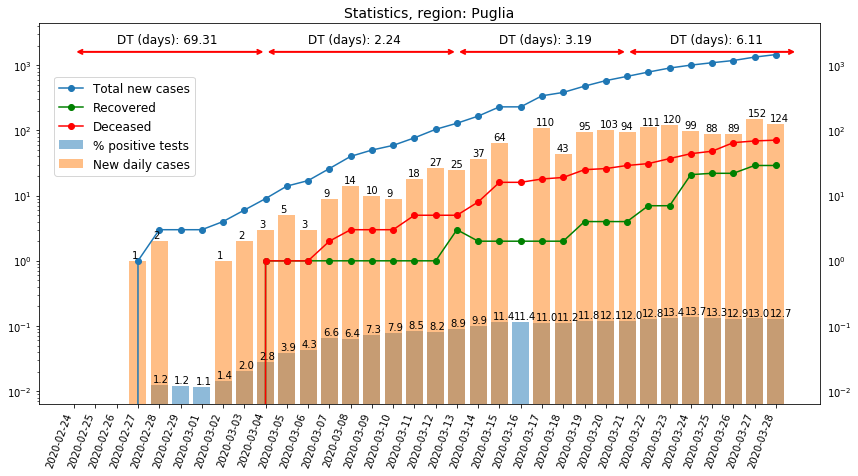

In [270]:
analyze_region('Puglia', data, nchunks=4, save=False)

Date range: 2020-02-24 2020-03-03
Doubling time:  2.504 days; r2 score 0.989
Date range: 2020-03-04 2020-03-12
Doubling time:  3.499 days; r2 score 0.99
Date range: 2020-03-13 2020-03-20
Doubling time:  5.825 days; r2 score 0.986
Date range: 2020-03-21 2020-03-28
Doubling time:  11.144 days; r2 score 0.999


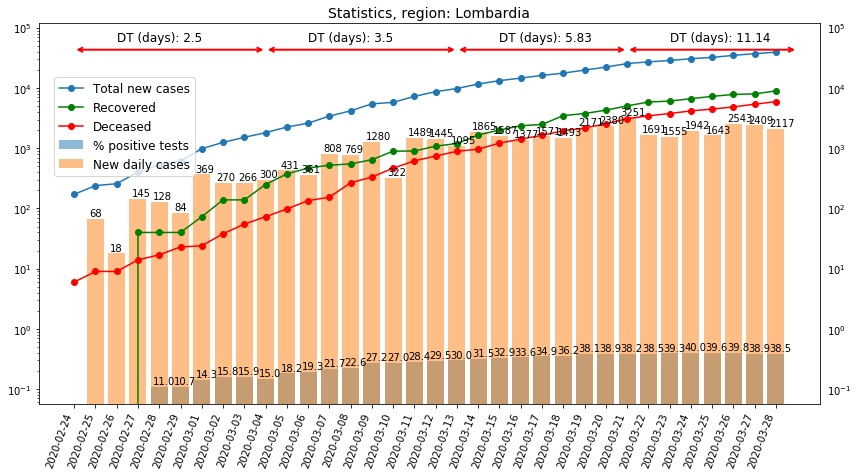

In [271]:
analyze_region('Lombardia', data, nchunks=4, save = True)

Date range: 2020-02-24 2020-03-03
Doubling time for new cases:  2.323 days; r2 score 0.863
Date range: 2020-03-04 2020-03-12
Doubling time for new cases:  4.396 days; r2 score 0.971
Date range: 2020-03-13 2020-03-20
Doubling time for new cases:  5.184 days; r2 score 0.99
Date range: 2020-03-21 2020-03-28
Doubling time for new cases:  8.67 days; r2 score 0.993


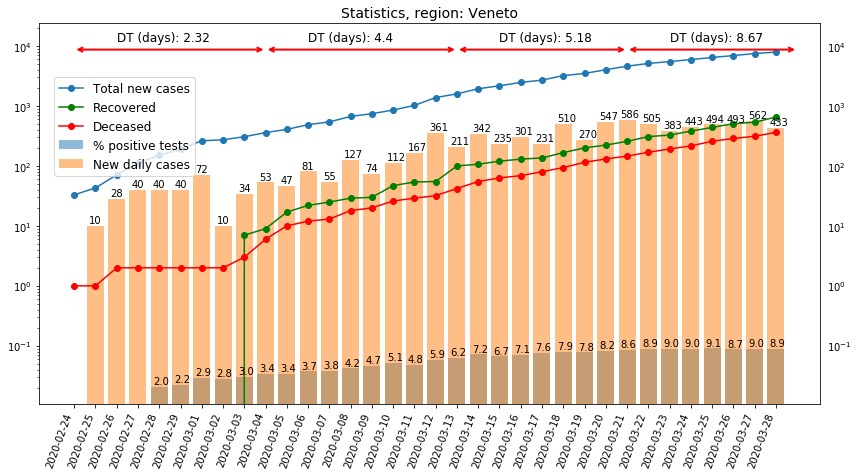

In [268]:
analyze_region('Veneto', data)

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Date range: 2020-02-24 2020-03-03
Doubling time:  69.315 days; r2 score -1.549
Date range: 2020-03-04 2020-03-12
Doubling time:  2.333 days; r2 score 0.93
Date range: 2020-03-13 2020-03-20
Doubling time:  3.558 days; r2 score 0.984
Date range: 2020-03-21 2020-03-28
Doubling time:  7.494 days; r2 score 0.994


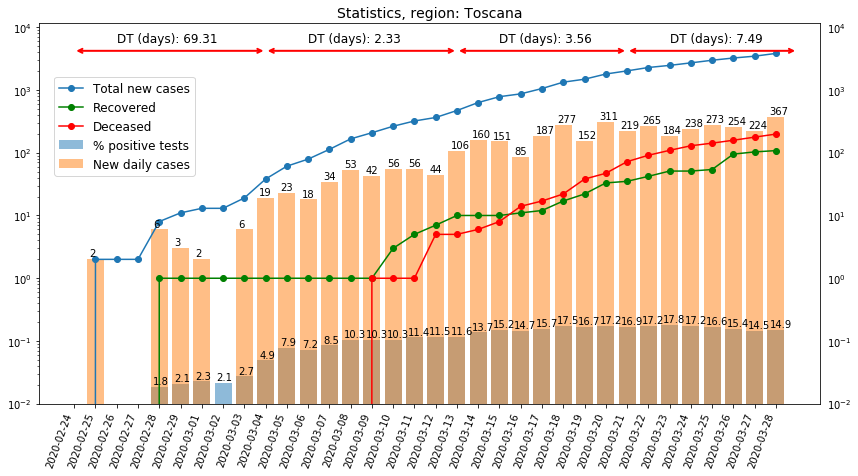

In [273]:
analyze_region('Toscana', data, nchunks=4, save= False)

Date range: 2020-02-24 2020-03-03
Doubling time:  4.47 days; r2 score 0.709
Date range: 2020-03-04 2020-03-12
Doubling time:  2.94 days; r2 score 0.978
Date range: 2020-03-13 2020-03-20
Doubling time:  3.719 days; r2 score 0.989
Date range: 2020-03-21 2020-03-28
Doubling time:  6.296 days; r2 score 0.986


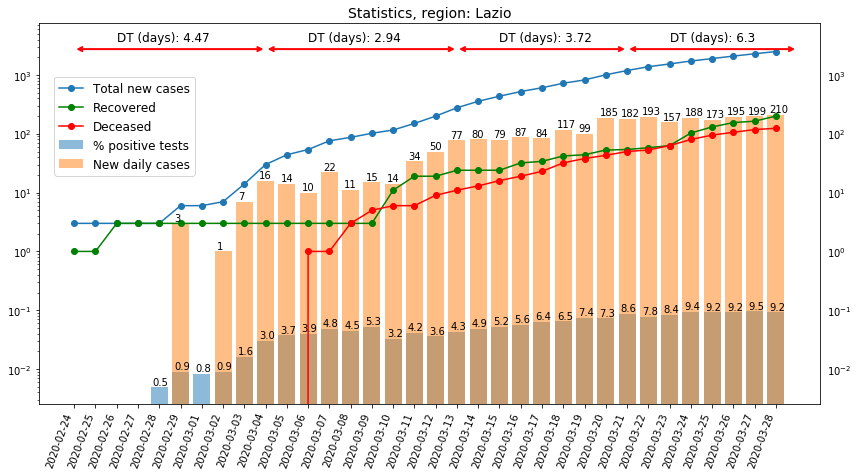

In [274]:
analyze_region('Lazio', data, nchunks=4)

Date range: 2020-02-24 2020-03-03
Doubling time:  1.692 days; r2 score 0.887
Date range: 2020-03-04 2020-03-12
Doubling time:  4.145 days; r2 score 0.958
Date range: 2020-03-13 2020-03-20
Doubling time:  4.982 days; r2 score 0.998
Date range: 2020-03-21 2020-03-28
Doubling time:  7.505 days; r2 score 0.972


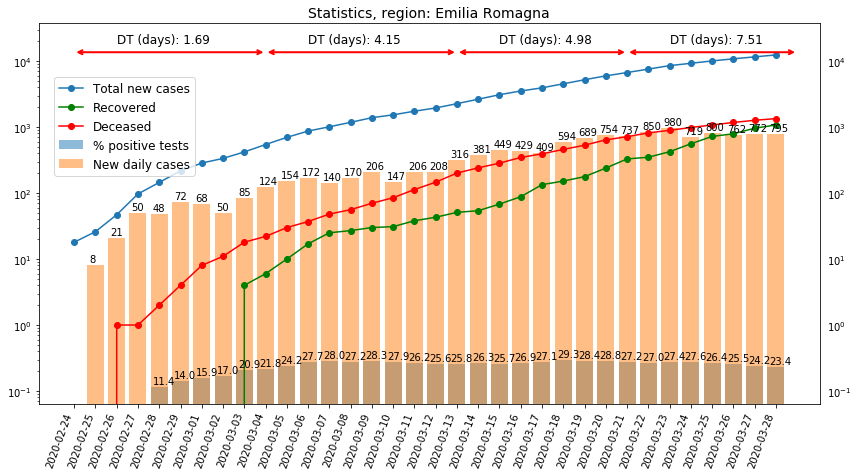

In [275]:
analyze_region('Emilia Romagna', data, save = False)

[0.43706165]
Date range: 2020-02-24 2020-03-03
Doubling time for new cases:  1.586 days; r2 score 0.84
[0.25874547]
Date range: 2020-03-04 2020-03-12
Doubling time for new cases:  2.679 days; r2 score 0.889
[0.20370738]
Date range: 2020-03-13 2020-03-20
Doubling time for new cases:  3.403 days; r2 score 0.991
[0.10733332]
Date range: 2020-03-21 2020-03-28
Doubling time for new cases:  6.458 days; r2 score 0.97


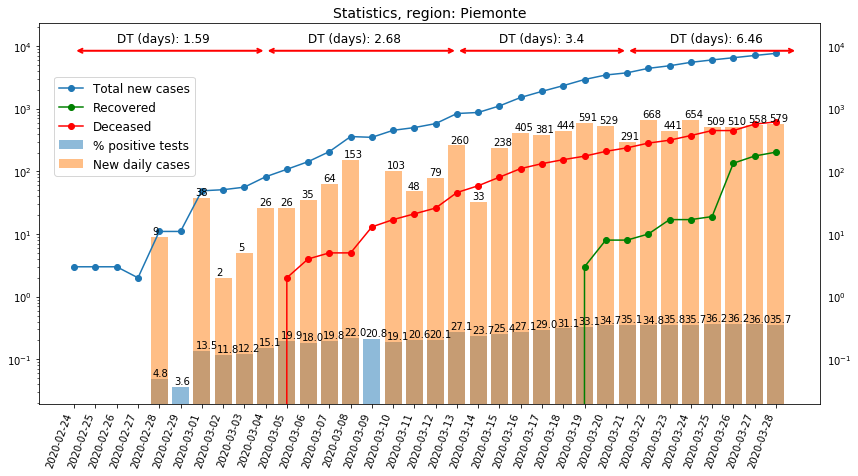

In [262]:
analyze_region('Piemonte', data, nchunks=4)

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.01]
Date range: 2020-02-24 2020-03-03
Doubling time for new cases:  69.315 days; r2 score -3.208
[0.22541006]
Date range: 2020-03-04 2020-03-12
Doubling time for new cases:  3.075 days; r2 score 0.973
[0.16085129]
Date range: 2020-03-13 2020-03-20
Doubling time for new cases:  4.309 days; r2 score 0.995
[0.15608886]
Date range: 2020-03-21 2020-03-28
Doubling time for new cases:  4.441 days; r2 score 0.948


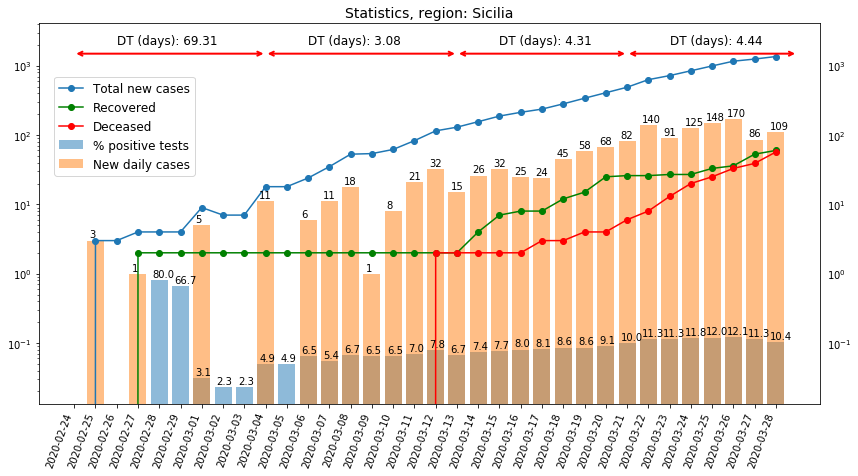

In [263]:
analyze_region('Sicilia', data)

0 0
[ 2.62111388 -0.14004836]
Doubling time for new cases, chunk 0 :  4.949 days
7 4
[ 0.23754359 -0.39282601]
Doubling time for new cases, chunk 1 :  1.765 days
14 50
[ 0.32323582 -0.32333317]
Doubling time for new cases, chunk 2 :  2.144 days
21 230
[ 4.53460574e+02 -5.46008713e-02]
Doubling time for new cases, chunk 3 :  12.695 days


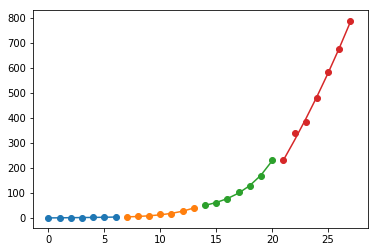

In [264]:
#old, validation

nchunks = 4

for i in range(nchunks):

        cases = np.array_split(dp.totale_casi.values, nchunks)[i]
        days = np.array_split(range(len(dp.totale_casi)), nchunks)[i]
        
        print(days.min(), cases.min())
    
        popt, pcov = curve_fit(lambda x, a, c: func_exp(x, a, c, cases.min() - a*np.exp(-c*days.min())) , days, cases, p0=(1, 1e-2))
        
        print(popt)
        
        plt.scatter(days, cases)
        
        plt.plot(days, func_exp(days, *popt, cases.min() - popt[0]*np.exp(-popt[1]*days.min())))
        
        print('Doubling time for new cases, chunk', i,': ', np.round(np.log(2)/-popt[1], 3), 'days')

    

In [239]:
!rm dpc-covid19-ita-andamento-nazionale.csv

In [240]:
!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv

--2020-03-28 18:47:25--  https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv
Resolving raw.githubusercontent.com... 151.101.132.133
Connecting to raw.githubusercontent.com|151.101.132.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2984 (2.9K) [text/plain]
Saving to: ‘dpc-covid19-ita-andamento-nazionale.csv’

dpc-covid19-ita-and 100%[===================>]   2.91K  --.-KB/s    in 0.001s  

2020-03-28 18:47:25 (4.62 MB/s) - ‘dpc-covid19-ita-andamento-nazionale.csv’ saved [2984/2984]



In [241]:
nat = pd.read_csv('dpc-covid19-ita-andamento-nazionale.csv')

In [242]:
nat.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare',
       'totale_attualmente_positivi', 'nuovi_attualmente_positivi',
       'dimessi_guariti', 'deceduti', 'totale_casi', 'tamponi', 'note_it',
       'note_en'],
      dtype='object')

In [247]:
dailies = np.array([nat.totale_casi[i] - nat.totale_casi[i-1] for i in range(1, len(nat.totale_casi))])

In [243]:
dailies_hosp = np.array([nat.totale_ospedalizzati[i] - nat.totale_ospedalizzati[i-1] for i in range(1, len(nat.totale_casi))])

In [244]:
dailies_ti = np.array([nat.terapia_intensiva[i] - nat.terapia_intensiva[i-1] for i in range(1, len(nat.totale_casi))])

In [245]:
dailies_dead = np.array([nat.deceduti[i] - nat.deceduti[i-1] for i in range(1, len(nat.totale_casi))])

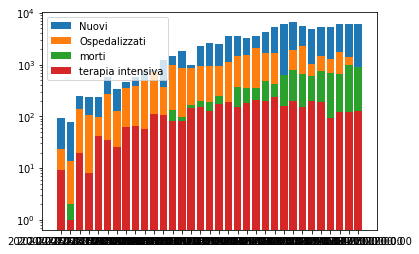

In [251]:
plt.bar(nat.data[1:], dailies, label = 'Nuovi')
plt.bar(nat.data[1:], dailies_hosp, label = 'Ospedalizzati')
plt.bar(nat.data[1:], dailies_dead, label = 'morti')
plt.bar(nat.data[1:], dailies_ti, label = 'terapia intensiva')
plt.legend()
plt.yscale('log')

In [210]:
dailies

array([  93,   78,  250,  238,  240,  566,  342,  466,  587,  769,  778,
       1247, 1492, 1797,  977, 2313, 2651, 2547, 3497, 3590, 3233, 3526,
       4207, 5322, 5986, 6557, 5560, 4789, 5249, 5210, 6153, 5959])